In [1]:
import distutils.spawn
import math
from matplotlib import rc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from models import FCResNet

In [2]:
sns.set(font_scale=1.5)

if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

In [3]:
from data import load_dataset

train_dl, test_dl, first_coord, nb_classes = load_dataset('MNIST', vectorize=True)

In [4]:
for i, data in enumerate(train_dl):
    if i == 0:
        print(data[0].shape)
        print(data[1].shape)

torch.Size([128, 784])
torch.Size([128])


In [5]:
default_config= {
    'width': 32,
    'depth': 200,
    'activation': 'ReLU',
    'init_final_initialization_noise': 1,
    'layers_initialization_noise': 1,
    'batch_norm': False,
    'skip_connection': True,
    'train_init': True,
    'train_final': True,
    'scaling': 'beta',
    'scaling_beta': 1.,
    'lr': 0.1}

In [21]:
dim_input = 64
nb_classes = 10
target = torch.LongTensor([1])

niter = 10
grid_depth = torch.linspace(10, 1e3, steps=20, dtype=int)
grid_beta = [0., 0.25, 0.5, 0.75, 1.]
results = []

for beta in grid_beta:
    for depth in grid_depth.numpy():
        for _ in range(niter):
            model_config = default_config
            model_config['scaling_beta'] = beta
            model_config['depth'] = depth
            
            x0 = torch.rand((1, dim_input))
            model = FCResNet(dim_input, nb_classes, **model_config)
            
            h_0 = model.init(x0)
            h_L = model.forward_hidden_state(h_0)
            output = model.final(h_L)
            
            h_0.retain_grad()
            h_L.retain_grad()

            # model.train()
            loss = model.loss(output, target)
            loss.backward()
                        
            h_0_grad = h_0.grad
            h_L_grad = h_L.grad
            
            results.append({
                'depth':depth, 
                'beta': beta, 
                'norm': float(torch.norm(h_L)/torch.norm(h_0)), 
                'norm_difference': float(torch.norm(h_L - h_0)),
                'norm_gradient_0': float(torch.norm(h_0_grad)),
                'norm_gradient_L': float(torch.norm(h_L_grad)),
                'norm_difference_gradient': float(torch.norm(h_L_grad - h_0_grad))
            })

In [43]:
df = pd.DataFrame(results)

In [31]:
print(df.head())

   depth  beta       norm  norm_difference  norm_gradient_0  norm_gradient_L  \
0     10   0.0   6.031346        21.489943         1.175141         0.127287   
1     10   0.0   9.510729        34.015106        10.759724         1.503349   
2     10   0.0  10.286562        30.739109         0.027619         0.005197   
3     10   0.0   4.426792        18.065538         6.435076         1.066185   
4     10   0.0   5.901206        16.643768         5.047879         0.628220   

   norm_difference_gradient  
0                  1.129857  
1                 10.683762  
2                  0.027299  
3                  5.938841  
4                  5.015068  


In [32]:
df.columns = ['depth', r'$\beta$', 'norm', 'norm_difference', 'norm_gradient_0', 'norm_gradient_L', 'norm_gradient_difference']

In [40]:
df['norm_gradient_quotient'] = df['norm_gradient_0'] / df['norm_gradient_L'] 

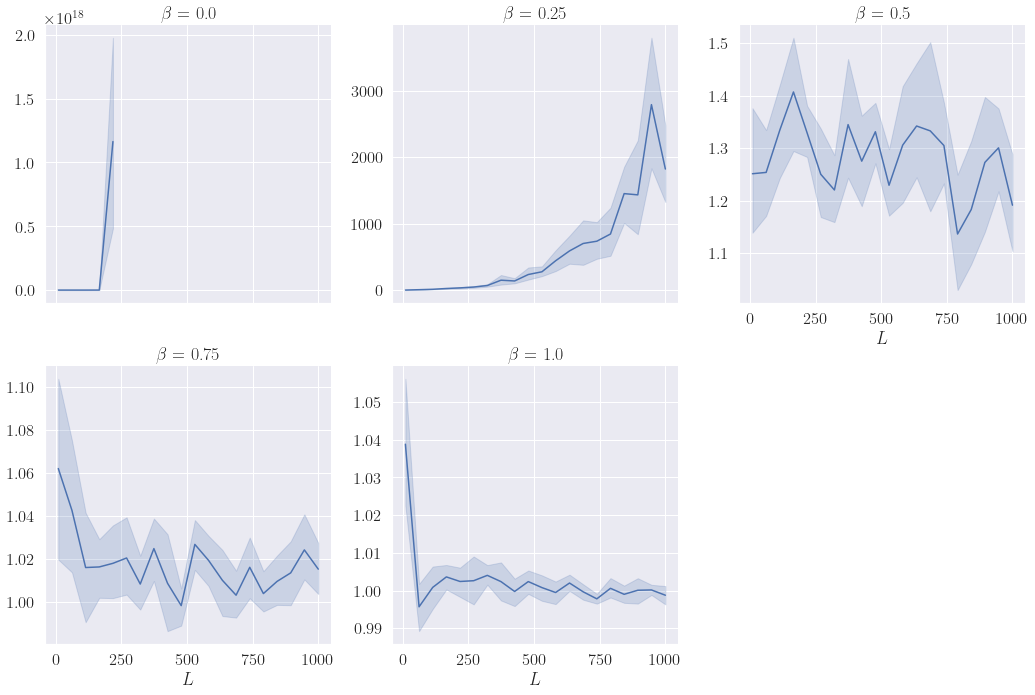

In [41]:
g = sns.relplot(
    x='depth', y='norm_gradient_quotient', col=r'$\beta$', col_wrap=3, data=df, kind='line', facet_kws=dict(sharey=False))

#g.axes[0].set_ylabel(r'$\|\frac{\partial \mathcal{L}}{\partial h_L}\|/ \|\frac{\partial \mathcal{L}}{\partial h_0}\|$', rotation=0, labelpad=40)

g.axes[0].set_ylabel(' ', rotation=0, labelpad=40)
g.axes[3].set_ylabel(' ', rotation=0, labelpad=40)
g.axes[2].set_xlabel(r'$L$')
g.axes[3].set_xlabel(r'$L$')
g.axes[4].set_xlabel(r'$L$')


plt.savefig('figures/scaling_init_norm_gradient_quotient.pdf', bbox_inches='tight')
plt.show()

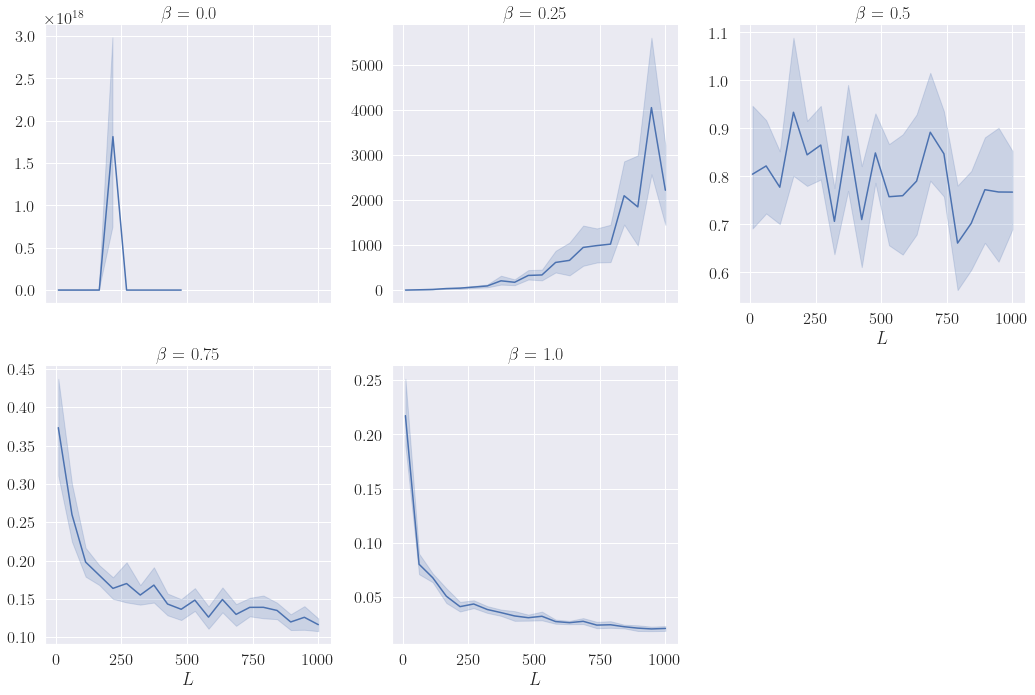

In [39]:
g = sns.relplot(
    x='depth', y='norm_gradient_difference', col=r'$\beta$', col_wrap=3, data=df, kind='line', facet_kws=dict(sharey=False))

g.axes[0].set_ylabel(' ', rotation=0, labelpad=40)
g.axes[3].set_ylabel(' ', rotation=0, labelpad=40)
g.axes[2].set_xlabel(r'$L$')
g.axes[3].set_xlabel(r'$L$')
g.axes[4].set_xlabel(r'$L$')

plt.savefig('figures/scaling_init_norm_gradient_difference.pdf', bbox_inches='tight')
plt.show()

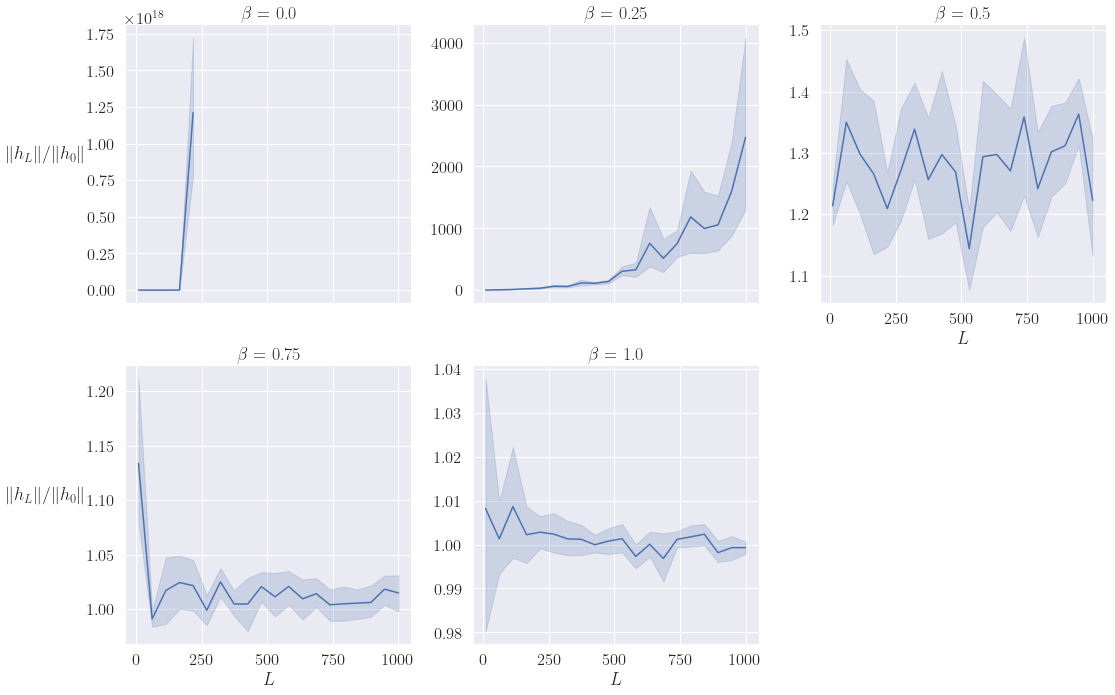

In [83]:
g = sns.relplot(
    x='depth', y='norm', col=r'$\beta$', col_wrap=3, data=df, kind='line', facet_kws=dict(sharey=False))

g.axes[0].set_ylabel(r'$\|h_L\|/\|h_0\|$', rotation=0, labelpad=40)
g.axes[3].set_ylabel(r'$\|h_L\|/\|h_0\|$', rotation=0, labelpad=40)
g.axes[2].set_xlabel(r'$L$')
g.axes[3].set_xlabel(r'$L$')
g.axes[4].set_xlabel(r'$L$')

plt.savefig('figures/scaling_init_norm.pdf', bbox_inches='tight')
plt.show()

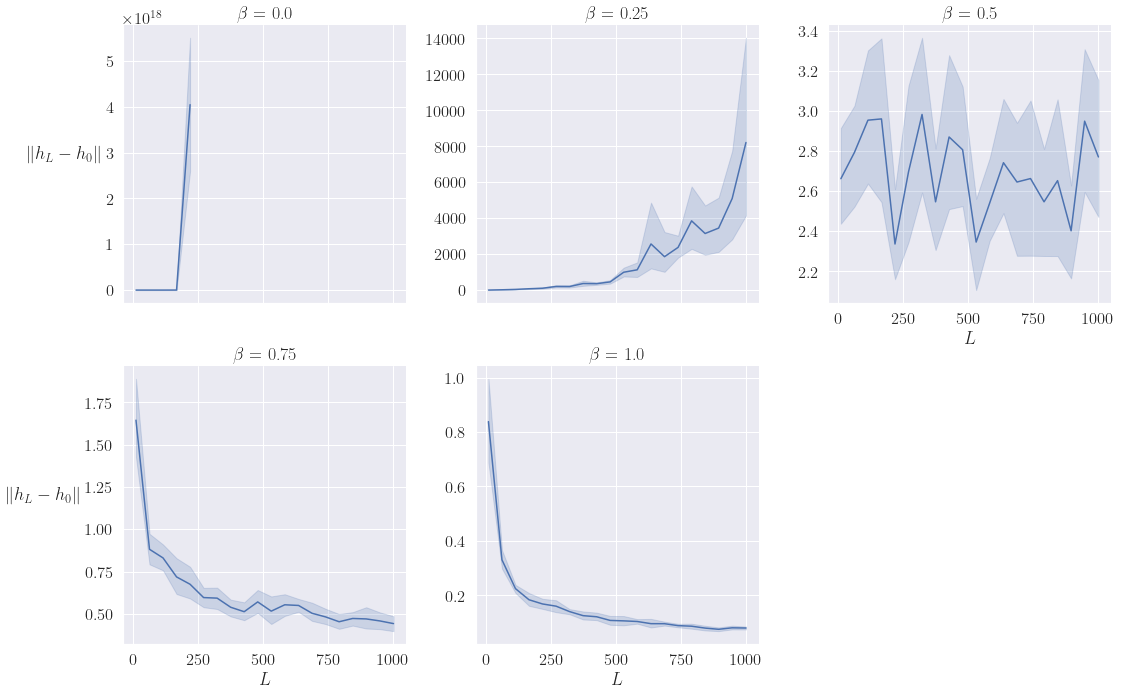

In [82]:
g = sns.relplot(
    x='depth', y='norm_difference', col=r'$\beta$', col_wrap=3, data=df, kind='line', facet_kws=dict(sharey=False))

g.axes[0].set_ylabel(r'$\|h_L-h_0\|$', rotation=0, labelpad=40)
g.axes[3].set_ylabel(r'$\|h_L-h_0\|$', rotation=0, labelpad=40)
g.axes[2].set_xlabel(r'$L$')
g.axes[3].set_xlabel(r'$L$')
g.axes[4].set_xlabel(r'$L$')


plt.savefig('figures/scaling_init_norm_difference.pdf', bbox_inches='tight')
plt.show()